# LibA-NAT1 Pathway
We know that
$$\text{H}_2\text{O} + \text{Linuron} \longrightarrow \text{N,O-dimethylhydroxylamine} + \text{CO}_2 + \text{3,4-dichloroaniline.}$$
It is known that purified LibA is a monomeric linuron hydrolase of ∼55 kDa with a $K_m$ and a $V_{max}$ for linuron of 5.8 μM and 0.16 nmol per min. for Variovorax with an unknown enzyme concentration, respectively [Bers11, https://www.ncbi.nlm.nih.gov/pubmed/22003008]. 

The second step in the reaction involving NAT1 is characterized in [Rodriguesa-Lima06]. The rate for 3,4-dichloroaniline degradation with NAT1 is computed to be $68 \pm 8$ nmol. per min. per mg. of enzyme. In addition, the ratio of $\frac{K_m}{V_{max}}$ is estimated to be $0.005$ per min. for the NAT-dependent pathway for the biotransformation of 3,4-DCA within Mesorhizobium loti.

This ratio does not give us enough information for our reaction network. This is why we will (for the time being) assume a constant concentration of NAT1 $\text{NAT1_conc}$.

## Computations
We will first load the relevant Julia packages

In [1]:
using DiffEqBiological;
using DifferentialEquations;
using Plots;
using Latexify;

We will now construct our reaction network.

In [2]:
rs = @reaction_network begin
  mm(DCA,V_max_LibA,K_m_LibA), Ln → DCA # Linuron to DCA reaction through LibA, irrelevant molecules are ignored, see below.
  rate_NAT1, DCA → DCAA # NAT1 reaction, irrelevant molecules are ignored see below
    end V_max_LibA K_m_LibA rate_NAT1

(::reaction_network) (generic function with 2 methods)

The $mm(X,v,K)$ function is DiffEqBiological's Hill function. The first argument encodes the substrate in question and $V, K$ are the paramters for the Hill function. Although LibA also needs water, for the purpose of modelling, it is safe to ignore it because it is relatively infinite. With the model eventually shwon on the wiki, the water concentration will be shown and taken into account but it is not necessary at this stage (the qualitative and even maybe quantitative differences in the solutions for not including all of the reactatns and products are going to be minimal since not including them is essentially the same as asssuming that we will never have to worry about or measure their concentrations). The same goes for the NAT1. When we start considering varying enzyme concentrations due to the expression of the enxymes, this will come back to bite us but it is not a problem for now. The differential equations are:

In [3]:
latexify(rs)

L"\begin{align}
\frac{dLn}{dt} =&  - \frac{V_{max\_LibA} \cdot DCA}{K_{m\_LibA} + DCA} \cdot Ln \\
\frac{dDCA}{dt} =& \frac{V_{max\_LibA} \cdot DCA}{K_{m\_LibA} + DCA} \cdot Ln - rate_{NAT1} \cdot DCA \\
\frac{dDCAA}{dt} =& rate_{NAT1} \cdot DCA \\
\end{align}
"

A little less useful but I still think its cool that I can do this. It'll become important in other modelling. THis is the chemical reaction network.

In [4]:
latexify(rs; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ Ln &->[\frac{V_{max\_LibA} \cdot DCA}{K_{m\_LibA} + DCA}] DCA}\\
\ce{ DCA &->[rate_{NAT1}] DCAA}
\end{align}
"

From above, we have these parameters.

In [5]:
V_max_LibA = 0.16;# nmol per min.
K_m_LibA = 5800.;  # nmol
NAT1_rate_per_mg = 68.;   # nmol per min. per mg.
NAT1_conc = 0.01;# arbitrarily set to 10 ng for now, not sure how valid it is.
rate_NAT1 = NAT1_conc*NAT1_rate_per_mg;

p_10 = (V_max_LibA, K_m_LibA, rate_NAT1);

We now assume that there is 622000000 nmol of Linuron per plate (due to a calculation by Nicki), which is why I safely assumed that there is approximate 10 ng of NAT1 (again, ballpark). In addition, the solvers require that there is a non-zero amount of DCA and DCAA already present so we set the initial conditions as follows:

In [6]:
u0 = [622000000., 0.001, 0.001];
tspan = (0., 10.);

We will now setup the problem, solve it, and plot the solutions.

In [7]:
prob_10 = ODEProblem(rs, u0, tspan, p_10);
sol_10 = solve(prob_10, DynamicSS(Tsit5()));

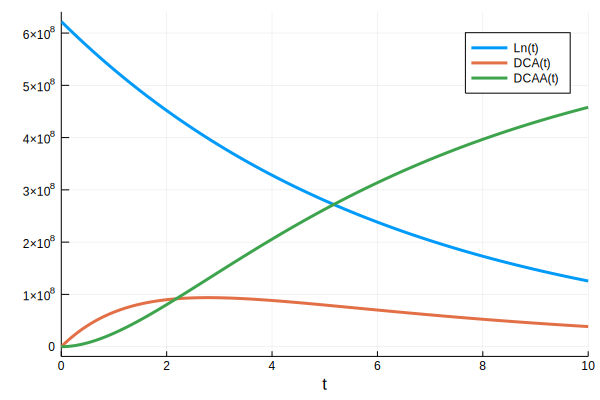

In [8]:
plot(sol_10)

We see that if we assume we have 100 ng, the DCA concentration drops to much lower.

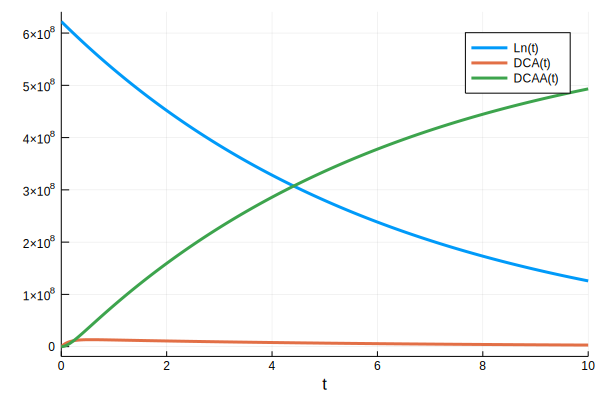

In [9]:
NAT1_conc = 0.1;# 100 ng now
rate_NAT1 = NAT1_conc*NAT1_rate_per_mg;

p_100 = (V_max_LibA, K_m_LibA, rate_NAT1);

prob_100 = ODEProblem(rs, u0, tspan, p_100);
sol_100 = solve(prob_100, DynamicSS(Tsit5()));

plot(sol_100)

Going up one more order, we see that it drops to essentially zero.

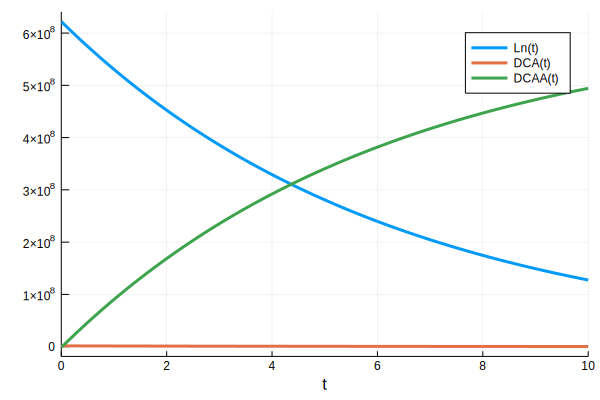

In [10]:
NAT1_conc = 1.;# 1 mg now
rate_NAT1 = NAT1_conc*NAT1_rate_per_mg;

p_1000 = (V_max_LibA, K_m_LibA, rate_NAT1);

prob_1000 = ODEProblem(rs, u0, tspan, p_1000);
sol_1000 = solve(prob_1000, DynamicSS(Tsit5()));

plot(sol_1000)

Since the Hill function only models substrate concentration against reaction rates, the enzyme concentration is not being modelled quantitatively (thereby assumed to be infinite). We can easily modify the above to take into account varying enzyme concentrations. In the case of the NAT1 enzyme, this directly corresponds to varying NAT1_conc which is easy since Julia allows you to define your own function for the reaction parameters which would in our case be varying over time against another "HIll-ish" function or one that better approximates gene expression. In the case of LibA, incorporating varying concentrations of LibA is done by moving away from the Hill function into a form such as for NAT1 (using the paramters to derive new ones and if its not possible, measuring them/finding them in literature) and then repeating what we did for NAT1 for LibA.

Now if we start to consider both enzymes (LibA and NAT1) under the same promoter, we see that both will be generated at the same rate. We can choose to model both the mRNA and protein production and decay but we do not have rates for this so we're just gonna use the quasi-steady state approximation. This changes our reaction network to

In [5]:
rss = @reaction_network begin
    r_1, ∅ → NAT1 + libA
    r_2, NAT1 → ∅
    r_3, libA → ∅
    mm(DCA, V_max_LibA,K_m_LibA), Ln + libA → DCA + libA # Linuron to DCA reaction through LibA, irrelevant molecules are ignored, see below
    rate_NAT1*NAT1, DCA → DCAA # NAT1 reaction, irrelevant molecules are ignored see below
end r_1 r_2 r_3 V_max_LibA K_m_LibA rate_NAT1

(::reaction_network) (generic function with 2 methods)